## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u
from astropy.table import Table

from gammapy.irf import EnergyDispersion, EffectiveAreaTable
from gammapy.spectrum import SpectrumDataset
from gammapy.modeling import Fit
from gammapy.modeling.models import TableModel
from gammapy.irf import load_cta_irfs

In [2]:
!gammapy info


System:

	python_executable      : /Users/jer/anaconda/bin/python 
	python_version         : 3.6.8      
	machine                : x86_64     
	system                 : Darwin     


Gammapy package:

	path                   : /Users/jer/anaconda/lib/python3.6/site-packages/gammapy 
	version                : 0.13       


Other packages:

	numpy                  : 1.12.1     
	scipy                  : 0.19.1     
	matplotlib             : 3.1.0      
	cython                 : 0.25.2     
	astropy                : 2.0.12     
	astropy_healpix        : 0.2.1      
	reproject              : 0.3.1      
	sherpa                 : 4.9.0      
	pytest                 : 3.0.7      
	sphinx                 : 1.5.6      
	healpy                 : 1.10.3     
	regions                : 0.4        
	iminuit                : 1.3.6      
	naima                  : 0.8        
	uncertainties          : 3.0.1      


Gammapy environment variables:

	GAMMA_CAT              : /Users/jer/git/gammapy/gamma

### Prepare model from an ASCII Table

In [3]:
opts = {
   'format': 'ascii',
   'names': ['e_ref', 'e2_flux'], 
}

t = Table.read('../datasets/spectra_CIRELLI11_EW_GAMMA_m2000.txt', **opts)

# Let's add some units
t['e_ref'].unit, t['e2_flux'].unit = "MeV", "cm-2 s-1 MeV"

In [4]:
t

e_ref,e2_flux
MeV,MeV / (cm2 s)
float64,float64
1000.0,3.61e-12
1089.8,3.95e-12
1187.8,4.33e-12
1294.5,4.73e-12
1410.8,5.16e-12
1537.5,5.62e-12
1675.6,6.11e-12
1826.2,6.64e-12


In [5]:
### Boost flux
t['dnde'] = t['e2_flux']/(t['e_ref']*t['e_ref'])*10e3
t['dnde'].unit = "cm-2 s-1 MeV-1"

In [6]:
t

e_ref,e2_flux,dnde
MeV,MeV / (cm2 s),1 / (cm2 MeV s)
float64,float64,float64
1000.0,3.61e-12,3.61e-14
1089.8,3.95e-12,3.325856359177129e-14
1187.8,4.33e-12,3.069030853357e-14
1294.5,4.73e-12,2.8226500058705753e-14
1410.8,5.16e-12,2.5925002063951717e-14
1537.5,5.62e-12,2.3774208473792055e-14
1675.6,6.11e-12,2.176208523032706e-14
1826.2,6.64e-12,1.9910006530602085e-14


In [7]:
mask = t['dnde']>1e-30
t = t[mask]

In [8]:
t

e_ref,e2_flux,dnde
MeV,MeV / (cm2 s),1 / (cm2 MeV s)
float64,float64,float64
1000.0,3.61e-12,3.61e-14
1089.8,3.95e-12,3.325856359177129e-14
1187.8,4.33e-12,3.069030853357e-14
1294.5,4.73e-12,2.8226500058705753e-14
1410.8,5.16e-12,2.5925002063951717e-14
1537.5,5.62e-12,2.3774208473792055e-14
1675.6,6.11e-12,2.176208523032706e-14
1826.2,6.64e-12,1.9910006530602085e-14


### Define spectral model

In [9]:
offset = 0.5 * u.deg
energy = t['e_ref'].data * t['e_ref'].unit
values = t['dnde'].data * t['dnde'].unit

In [10]:
model = TableModel(
    energy=energy,
    values=values,
)

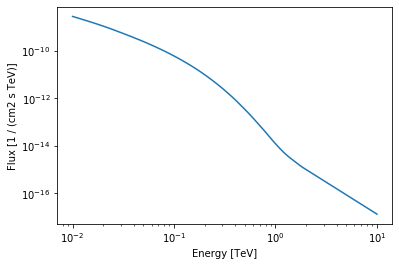

In [11]:
model.plot(energy_range=[1e-2, 10] * u.TeV)

### Load IRFs

In [12]:
irfs = load_cta_irfs("$CTADATA/caldb/data/cta/1dc/bcf/South_z40_50h/irf_file.fits")

NDDataArray summary info
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 42        
	node type  : edges     
	edges min  : 1.3e-02 TeV
	edges max  : 2.0e+02 TeV
	interp     : log       
MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 6         
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 6.0e+00 deg
	interp     : lin       
Data           : size =   252, min =  0.000 m2, max = 7238342.000 m2



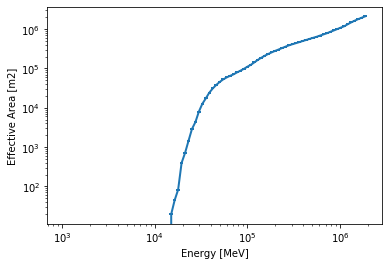

In [13]:
aeff = irfs['aeff'].to_effective_area_table(offset=offset, energy=energy)
aeff.plot()
plt.loglog()
print(irfs['aeff'].data)

NDDataArray summary info
MapAxis

	name       : e_true    
	unit       : 'MeV'     
	nbins      : 88        
	node type  : edges     
	edges min  : 1.0e+03 MeV
	edges max  : 1.9e+06 MeV
	interp     : log       
MapAxis

	name       : e_reco    
	unit       : 'MeV'     
	nbins      : 88        
	node type  : edges     
	edges min  : 1.0e+03 MeV
	edges max  : 1.9e+06 MeV
	interp     : log       
Data           : size =  7744, min =  0.000, max =  1.000



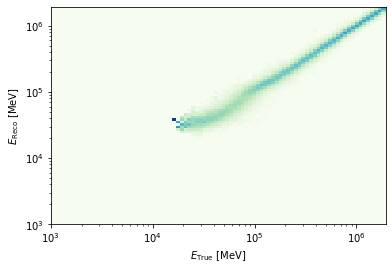

In [14]:
edisp = irfs['edisp'].to_energy_dispersion(
    offset=offset, e_true=energy, e_reco=energy
)
edisp.plot_matrix()
print(edisp.data)

### Simulate data

In [15]:
# observation time
livetime = 5 * u.h

In [16]:
dataset = SpectrumDataset(
    aeff=aeff, edisp=edisp, model=model, livetime=livetime, obs_id=0
)

dataset.fake(random_state=42)

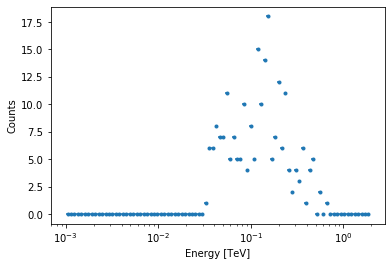

In [17]:
# Take a quick look at the simulated counts
dataset.counts.plot()